# Softmax classification

In this exercise, you will implement a softmax classifier for multi-class classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Loading the data

Let's now import the `digits` dataset provided by `scikit-learn`:

<https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html>

It contains 1797 small (8x8) black and white images of digits between 0 and 9. 

The two following cells load the data and visualize 16 images chosen randomly.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

N, w, h = digits.images.shape
d = w * h # number of pixels
c = len(digits.target_names) # number of classes

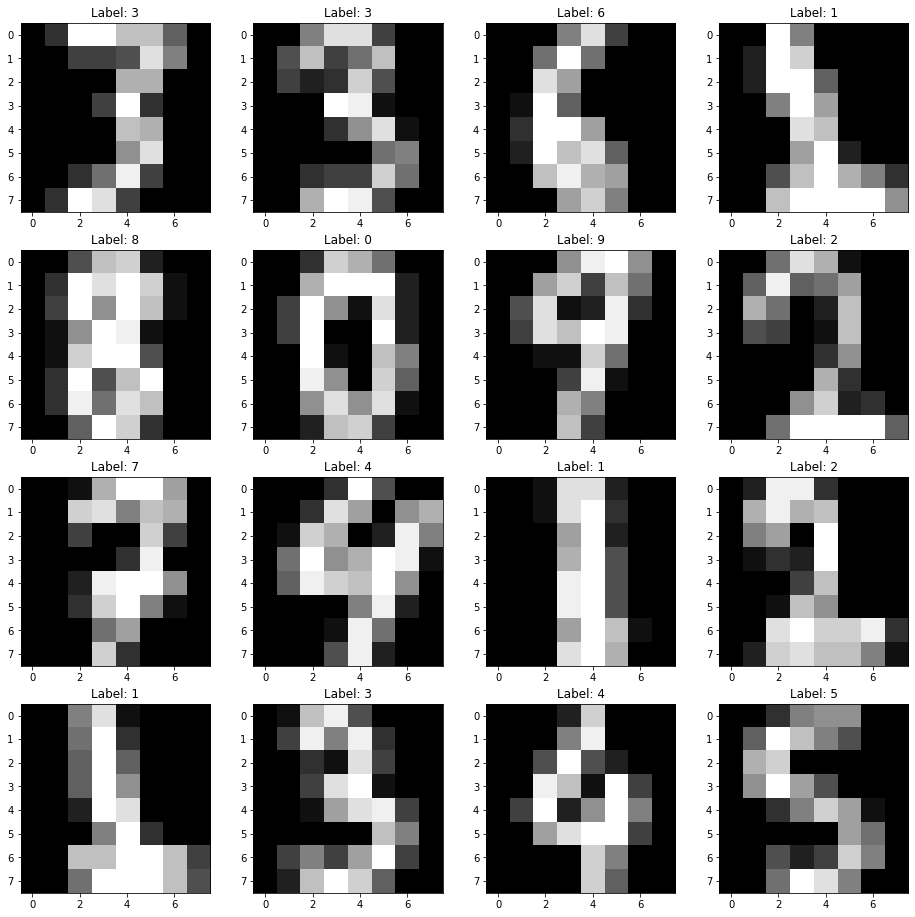

In [3]:
rng = np.random.default_rng()
indices = rng.choice(N, 16)
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digits.images[indices[i], :], cmap="gray")
    plt.title("Label: "+ str(digits.target[indices[i]]))
plt.show()

Digits are indeed to be recognized, the hope being that they are linearly separable and we can apply a softmax classifier directly on the pixels. 

The only problem is that each image is a 8x8 matrix, while we want vectors for our model. Fortunately, that is very easy with `reshape`:

In [4]:
X = digits.images.reshape((N, d))
print(X.shape)

(1797, 64)


Let's know have a look at the targets, i.e. the ground truth / labels of each digit:

In [5]:
labels = digits.target
print(labels)
print(labels.shape)

[0 1 2 ... 8 9 8]
(1797,)


Each label is an integer between 0 and 9, while our softmax classifier expects a **one-hot-encoded** vector of 10 classes, with only one non-zero element, for example for digit 3:

$$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$$

To do the conversion, we can once again use a built-in method of `scikit-learn`:

In [6]:
from sklearn.preprocessing import OneHotEncoder

t = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()

print(t)
print(t.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(1797, 10)


**Q:** Split the data into a training set `X_train, t_train` and a test set `X_test, t_test` using `scikit-learn` (e.g. with a ratio 70/30).

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

print(N_train, "training samples,", N_test, "test samples.")

1257 training samples, 540 test samples.


## Softmax linear classifier

Let's remember the structure of the softmax linear classifier: the input vector $\mathbf{x}$ is transformed into a **logit score** vector $\mathbf{z}$ using a weight matrix $W$ and a bias vector $\mathbf{b}$:

$$
    \mathbf{z} = W \times \mathbf{x} + \mathbf{b}
$$

This logit score has one element per class, so the weight matrix must have a size $(c, d)$, where $c$ is the number of classes (3) and $d$ is the number of dimensions of the input space (2). The bias vector has 3 elements (one per class).

The logit score is turned into probabilities using the **softmax** operator:

$$
    y_j = P(\text{class = j}) = \frac{\exp(z_j)}{\sum_k \exp(z_k)}
$$

The following Python function allows to turn any vector $\mathbf{z}$ (numpy array) into softmax probabilities:

In [8]:
def softmax(z):
    e = np.exp(z - z.max())
    return e/np.sum(e)

**Q:** Experiment with the `softmax()` to understand its function. Pass it different numpy arrays (e.g. [-1, 0, 2]) and print or plot the corresponding probabilities.  

In [9]:
z = np.array([-1, 0, 2])
s = softmax(z)
print(s)

[0.04201007 0.1141952  0.84379473]


The loss function to use is the **cross-entropy** or **negative log-likelihood**, defined for a single example as:

$$
    \mathcal{l}(W, \mathbf{b}) =   - \mathbf{t} \cdot \log \mathbf{y} = - \log y_j 
$$

where $\mathbf{t}$ is a one-hot encoding of the class of the example and $j$ is the index of the corresponding class.

After doing the derivations, we obtain the following learning rules for $W$ and $\mathbf{b}$ to minimize the loss function:

$$
    \Delta W = \eta \, (\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T
$$

$$
    \Delta \mathbf{b} = \eta \, (\mathbf{t} - \mathbf{y})
$$

Note that because $W$ is a $(c, d)$ matrix, $\Delta W$ too. $(\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T$ is therefore the **outer product** between the error vector $\mathbf{t} - \mathbf{y}$ ($c$ elements) and the input vector $\mathbf{x}$ ($d$ elements).

## Implementation

You will now modify your implementation of the online Perceptron algorithm from last week.

Some things to keep in mind:

* `W` must now be defined as a $(c, d)$ matrix (numpy array) and `b` as a vector with $c$ elements. Both can be initialized to 0.

* When computing the logit score $\mathbf{z} = W \times \mathbf{x} + \mathbf{b}$, remember that `W` is now a matrix, so its position will matter in the dot product `np.dot`.

* Use the `softmax()` function defined above on the whole vector instead of `np.sign()` or `logistic` to get the prediction $\mathbf{y}$.

* For $\Delta W$, you will need the **outer** product between the vectors $\mathbf{t} - \mathbf{y}_\text{train}$ and $\mathbf{x}_\text{train}$. Check the doc for `np.outer()`.

* The one-hot encoding of the class of the example $i$ is now a vector with 10 elements `t_train[i, :]`. You can get the index of the corresponding class by looking at the position of its maximum with `t_train[i, :].argmax()`.

* Similarly, the predicted class by the model can be identified by the class with the maximum probability: `y.argmax()`.

* Do not forget to record and plot the evolution of the training error and loss. Compute the test error and loss at the end of learning.

* Pick the right learning rate and number of epochs.

**Q:** Let's go.

Final training error: 0.0
Final training loss: 0.005902052488010588
Test error: 0.046296296296296294
Test loss: 0.20035874867574222


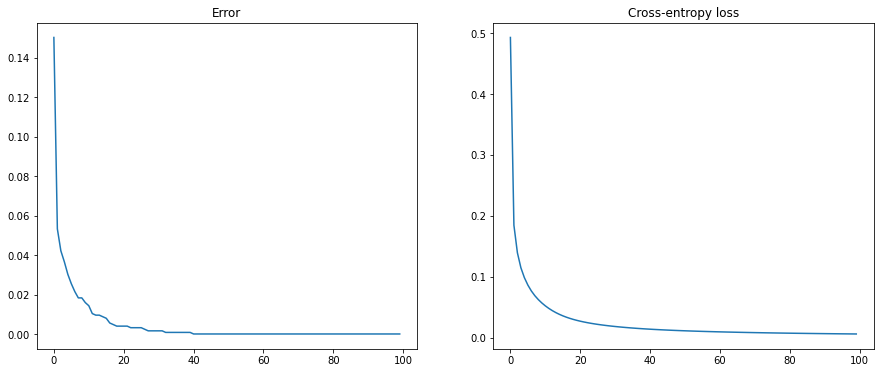

In [10]:
# Parameters
eta = 0.001
nb_epochs = 100

# Initialize the weight matrix and bias vector
W = np.zeros((c, d))
b = np.zeros(c)

# Perceptron algorithm
training_errors = []
training_losses = []

for epoch in range(nb_epochs):
    error = 0
    loss = 0.
    
    # Iterate over all training examples
    for i in range(N_train):
        
        # Prediction
        z = np.dot(W, X_train[i, :]) + b
        
        # Probability
        y = softmax(z)
        
        # Update the weight
        W += eta * np.outer((t_train[i, :] - y), X_train[i, :])
        
        # Update the bias
        b += eta * (t_train[i, :] - y) 
        
        # Increment the error if the maximum probability is different from the class
        if y.argmax() != t_train[i, :].argmax():
            error += 1
        
        # Accumulate the loss
        loss -= np.log(y[t_train[i, :].argmax()])
        
    training_errors.append(error/N_train)
    training_losses.append(loss/N_train)

print("Final training error:", error/N_train)
print("Final training loss:", loss/N_train)

# Test error
test_error = 0
test_loss = 0

# Iterate over all test examples
for i in range(N_test):

    # Prediction
    z = np.dot(W, X_test[i, :]) + b

    # Probability
    y = softmax(z)

    # Increment the error if the maximum probability is different from the class
    if y.argmax() != t_test[i, :].argmax():
        test_error += 1

    # Accumulate the loss
    test_loss -= np.log(y[t_test[i, :].argmax()])

print("Test error:", test_error/N_test)
print("Test loss:", test_loss/N_test)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(training_errors)
plt.title("Error")
plt.subplot(122)
plt.plot(training_losses)
plt.title("Cross-entropy loss")
plt.show()

**Q:** With a small learning rate (0.001), what is the final training error and loss of the model? Is it what you expected? Why do they evolve like this? What about the test error/loss?

*Hint:* you may need to avoid plotting the error/loss during the first 20 epochs or so to observe the effect.

**A:** The training error reaches quickly 0, but the loss still decreases for a number of epochs. This is because the probability vector `y` is a correct prediction for the class (the maximum probability corresponds to the correct class) but not with a probability of 1 yet. The loss continues to evolve even when there is no error, as it wants to bring the probability vector as close as possible to a binary vector.

This is the main difference with the mean square error (mse) loss function: as soon as there are no errors, the mse loss becomes 0 and learning stops. In classification problems, one should therefore track the loss function, not the training error.

The test error is higher than the final training error. as the examples were not use for training. This is a classical sign of **overfitting**, although the model is linear. Regularization may help.

**Q:** The following cell samples 12 misclassified images from the test and shows the predicted class together with the ground truth. What do you think?

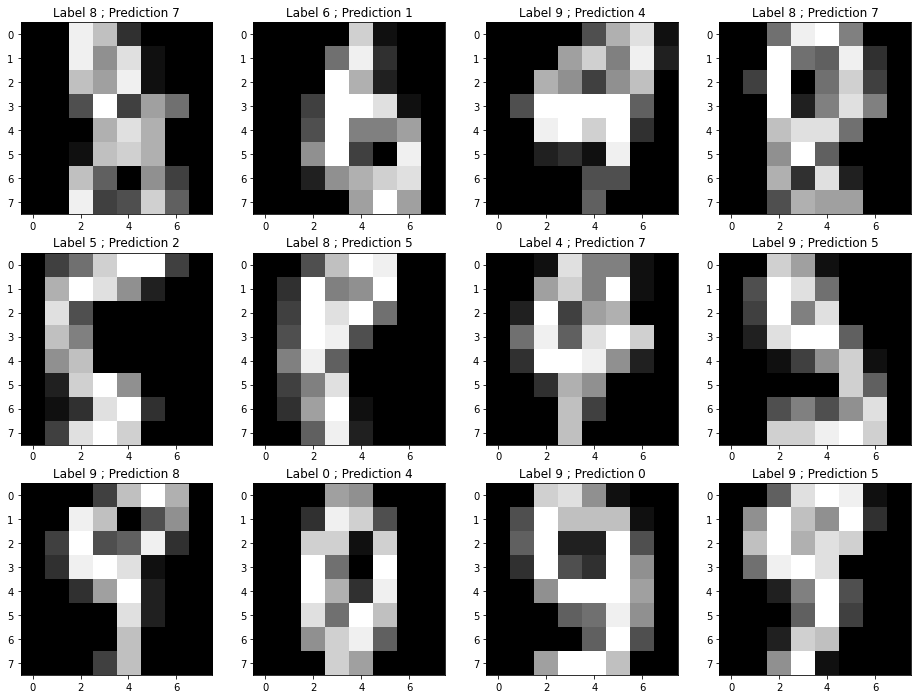

In [11]:
misclassified = []

for i in range(N_test):
    c = softmax(np.dot(W, X_test[i, :]) + b).argmax()
    if c != t_test[i, :].argmax():
        misclassified.append([X_test[i, :].reshape((8, 8)), t_test[i, :].argmax(), c])
        if len(misclassified) > 12: break
        
        
plt.figure(figsize=(16, 12))
for i in range(12):
    if i < len(misclassified):
        X, t, c = misclassified[i]
        plt.subplot(3, 4, i+1)
        plt.imshow(X, cmap="gray")
        plt.title("Label " + str(t) + " ; Prediction " + str(c))
    
plt.show()

**A:** for some misclassified images, the mistakes are quite understandable, so the classifier did a quite good job. Real-world data are never clean, there always are some bad annotations. It is therefore important to use methods that are robust to outliers, such as soft classifiers.